In [75]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [76]:
class KNN_Classifier:
    def __init__(self):
        X_train = None
        y_train = None
        k = None
        weights = None
        distance_metric = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, k: int, weights: str, distance_metric: str,
            **kwargs) -> None:
        """
        :brief: Fits the model to the training data.
        :param X_train: Training data.
        :param y_train: Training labels.
        :param k: Number of neighbors to consider.
        :param weights: Weights to use. default is uniform, but can be set to 'distance' to use the inverse of the
        distance as the weight.
        :param distance_metric: Distance metric to use.
        :param kwargs: Additional arguments to be passed to the distance metric function.
        :return: None.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        self.weights = weights
        self.distance_metric = distance_metric

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        :brief: Predicts the labels of the test data.
        :param X_test: Test data.
        :return: Predicted labels.
        """
        y_pred = np.zeros(len(X_test))

        for i, x_test in enumerate(X_test):
            distances = np.zeros(len(self.X_train))

            for j, x_train in enumerate(self.X_train):
                if self.distance_metric == "euclidean":
                    distances[j] = self.euclidean_distance(x_test, x_train)
                elif self.distance_metric == "manhattan":
                    distances[j] = self.manhattan_distance(x_test, x_train)

            nearest_neighbors = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_neighbors]
            y_pred[i] = np.bincount(nearest_labels).argmax()

        return y_pred

    def score(self, X_test: np.ndarray, y_test: np.ndarray) -> dict:
        """
        :brief: Calculates the accuracy of predictions and return all related data for further analysis, precision,
        recall, f1-score, confusion matrix, roc curve and auc, and precision-recall curve.
        :param X_test:
        :param y_test:
        :return: Dictionary containing various evaluation metrics.
        """
        y_pred = self.predict(X_test)

        accuracy = self.accuracy(y_test, y_pred)
        precision = self.precision(y_test, y_pred)
        recall = self.recall(y_test, y_pred)
        f1 = self.f1_score(y_test, y_pred)
        confusion = self.confusion_matrix(y_test, y_pred)
        roc = self.roc_curve(y_test, y_pred)
        auc = self.auc(y_test, y_pred)
        pr_curve = self.precision_recall_curve(y_test, y_pred)
        avg_precision = self.average_precision(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': confusion,
            'roc_curve': roc,
            'auc': auc,
            'precision_recall_curve': pr_curve,
            'average_precision': avg_precision
        }

    # ----------------------------------------------- Helper Functions ----------------------------------------------- #
    @staticmethod
    def euclidean_distance(p1: np.ndarray, p2: np.ndarray) -> float:
        """
        :brief: Calculates the Euclidean distance between two points.
        :param p1: A numpy array representing the first point in n-dimensional space.
        :param p2: A numpy array representing the second point in n-dimensional space.
        :return: The Euclidean distance between the two points.

        This function works by subtracting each dimension of p1 from the corresponding dimension of p2, squaring the
        result, summing all these squares together and then taking the square root of the sum.
        """
        assert (len(p1) == len(p2)), "Input vectors must have the same length"

        return np.sqrt(np.sum((p1 - p2) ** 2))

    @staticmethod
    def manhattan_distance(p1: np.ndarray, p2: np.ndarray) -> float:
        """
        :brief: Calculates the Manhattan distance between two points.
        :param p1: A numpy array representing the first point in n-dimensional space.
        :param p2: A numpy array representing the second point in n-dimensional space.
        :return: The Manhattan distance between the two points.

        This function works by subtracting each dimension of p1 from the corresponding dimension of p2, taking the
        absolute value of the result, and then summing all these absolute values together.
        """
        assert (len(p1) == len(p2)), "Input vectors must have the same length"
        return np.sum(np.abs(p1 - p2))

    @staticmethod
    def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the accuracy of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Accuracy.

        This function works by comparing each element of y_true with the corresponding element of y_pred. If they are
        equal, it's a correct prediction. The accuracy is then the number of correct predictions divided by the total
        number of predictions.
        """
        assert len(y_true) == len(y_pred), "Input vectors must have the same length"
        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(y_true)
        accuracy = correct_predictions / total_samples

        return accuracy

    @staticmethod
    def generalization_error(y_true: np.ndarray, y_pred: np.ndarray, loss_function: Callable) -> float:
        """
        :brief: Calculates the generalization error of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :param loss_function: Loss function that takes (y_true, y_pred) as input.
        :return: Generalization error.

        This function works by applying the loss function to each pair of corresponding elements in y_true and y_pred,
        and then taking the average of all the resulting loss values.
        """
        assert len(y_true) == len(y_pred), "Input vectors must have the same length"
        loss_values = loss_function(y_true, y_pred)
        generalization_error = np.mean(loss_values)

        return generalization_error

    @staticmethod
    def precision(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the precision of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Precision.

        This function works by calculating the number of true positive predictions (TP), and the number of false
        positive predictions (FP). The precision is then the number of true positive predictions divided by the sum
        of true positive and false positive predictions.
        """
        assert len(y_true) == len(y_pred), "Input vectors must have the same length"
        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_positive = np.sum((y_true == 0) & (y_pred == 1))
        precision = true_positive / (true_positive + false_positive)

        return precision

    @staticmethod
    def recall(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the recall of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Recall.

        This function works by calculating the number of true positive predictions (TP), and the number of false
        negative predictions (FN). The recall is then the number of true positive predictions divided by the sum of
        true positive and false negative predictions.
        """
        assert len(y_true) == len(y_pred), "Input vectors must have the same length"
        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_negative = np.sum((y_true == 1) & (y_pred == 0))
        recall = true_positive / (true_positive + false_negative)

        return recall

    @staticmethod
    def f1_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the F1 score of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: F1 score.

        This function works by calculating the precision and recall of the predictions, and then using these values
        to calculate the F1 score.
        """
        precision = KNN_Classifier.precision(y_true, y_pred)
        recall = KNN_Classifier.recall(y_true, y_pred)
        f1_score = 2 * (precision * recall) / (precision + recall)

        return f1_score

    @staticmethod
    def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :brief: Calculates the confusion matrix of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Confusion matrix.

        This function works by calculating the number of true positive, false positive, true negative and false
        negative predictions, and then storing these values in a 2x2 numpy array.
        """
        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_positive = np.sum((y_true == 0) & (y_pred == 1))
        true_negative = np.sum((y_true == 0) & (y_pred == 0))
        false_negative = np.sum((y_true == 1) & (y_pred == 0))

        confusion_matrix = np.array([[true_positive, false_positive], [false_negative, true_negative]])

        return confusion_matrix

    @staticmethod
    def roc_curve(y_true: np.ndarray, y_scores: np.ndarray) -> (list, list):
        """
        :brief: Calculates the ROC curve.
        :param y_true: True labels (ground truth).
        :param y_scores: Predicted probabilities for the positive class.
        :return: Lists of FPR and TPR for each threshold.

        This function works by iterating over thresholds, creating binary predictions, and calculating the TPR and FPR
         for each.
        """
        thresholds = sorted(np.unique(y_scores), reverse=True)
        fpr_list = []
        tpr_list = []

        for threshold in thresholds:
            y_pred = (y_scores >= threshold).astype(int)
            true_positive = np.sum((y_true == 1) & (y_pred == 1))
            false_positive = np.sum((y_true == 0) & (y_pred == 1))
            true_negative = np.sum((y_true == 0) & (y_pred == 0))
            false_negative = np.sum((y_true == 1) & (y_pred == 0))

            tpr = true_positive / (true_positive + false_negative)
            fpr = false_positive / (false_positive + true_negative)

            fpr_list.append(fpr)
            tpr_list.append(tpr)

        return fpr_list, tpr_list

    @staticmethod
    def auc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the AUC of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: AUC.

        This function works by calculating the ROC curve of the predictions, and then using the trapezoidal rule to
        calculate the area under the curve.
        """
        fpr, tpr = KNN_Classifier.roc_curve(y_true, y_pred)
        auc = np.trapz(tpr, fpr)

        return auc

    @staticmethod
    def precision_recall_curve(y_true: np.ndarray, y_pred: np.ndarray) -> (np.ndarray, np.ndarray):
        """
        :brief: Calculates the precision-recall curve of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Precision and recall.

        This function works by calculating the precision and recall for different thresholds, and then returning
        these values as numpy arrays.
        """
        thresholds = np.unique(y_pred)
        precision = np.zeros(len(thresholds))
        recall = np.zeros(len(thresholds))

        for i, threshold in enumerate(thresholds):
            y_pred_thresholded = (y_pred >= threshold).astype(int)
            confusion_matrix = KNN_Classifier.confusion_matrix(y_true, y_pred_thresholded)
            precision[i] = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
            recall[i] = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[1, 0])

        return precision, recall

    @staticmethod
    def average_precision(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        :brief: Calculates the average precision of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Average precision.

        This function works by calculating the precision-recall curve of the predictions, and then using the
        trapezoidal rule to calculate the area under the curve.
        """
        precision, recall = KNN_Classifier.precision_recall_curve(y_true, y_pred)
        average_precision = np.trapz(precision, recall)

        return average_precision

    @staticmethod
    def loss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :brief: Calculates the loss of predictions.
        :param y_true: True labels (ground truth).
        :param y_pred: Predicted labels.
        :return: Loss.

        This function works by calculating the loss for each pair of corresponding elements in y_true and y_pred,
        and then returning these values as a numpy array.
        """
        loss = (y_true - y_pred) ** 2

        return loss

    @staticmethod
    def plot_roc(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
                 k_range: tuple):
        """
        :brief: Plots the ROC curve for different values of k.
        :param X_train: Training data.
        :param y_train: Training labels.
        :param X_test: Test data.
        :param y_test: Test labels.
        :param k_range: Range of k values to consider.

        This function works by calling the roc_curve method to get the FPR and TPR for each value of k, and then using
        matplotlib to plot the ROC curve.
        """
        fpr_list, tpr_list = KNN_Classifier.roc_curve(X_train, y_train, X_test, y_test, k_range)

        for i in range(len(fpr_list)):
            plt.plot(fpr_list[i], tpr_list[i], label=f'k = {k_range[0] + i}')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Different Values of k')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(confusion_matrix: np.ndarray):
        """
        :brief: Plots the confusion matrix.
        :param confusion_matrix: Confusion matrix to plot.

        This function works by using seaborn to create a heatmap of the confusion matrix.
        """
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

In [77]:
wineQuality_white = pd.read_csv('Brute Force KNN for Binary Classification/winequality-white.csv', sep=';')
print(wineQuality_white.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [78]:
wineQuality_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


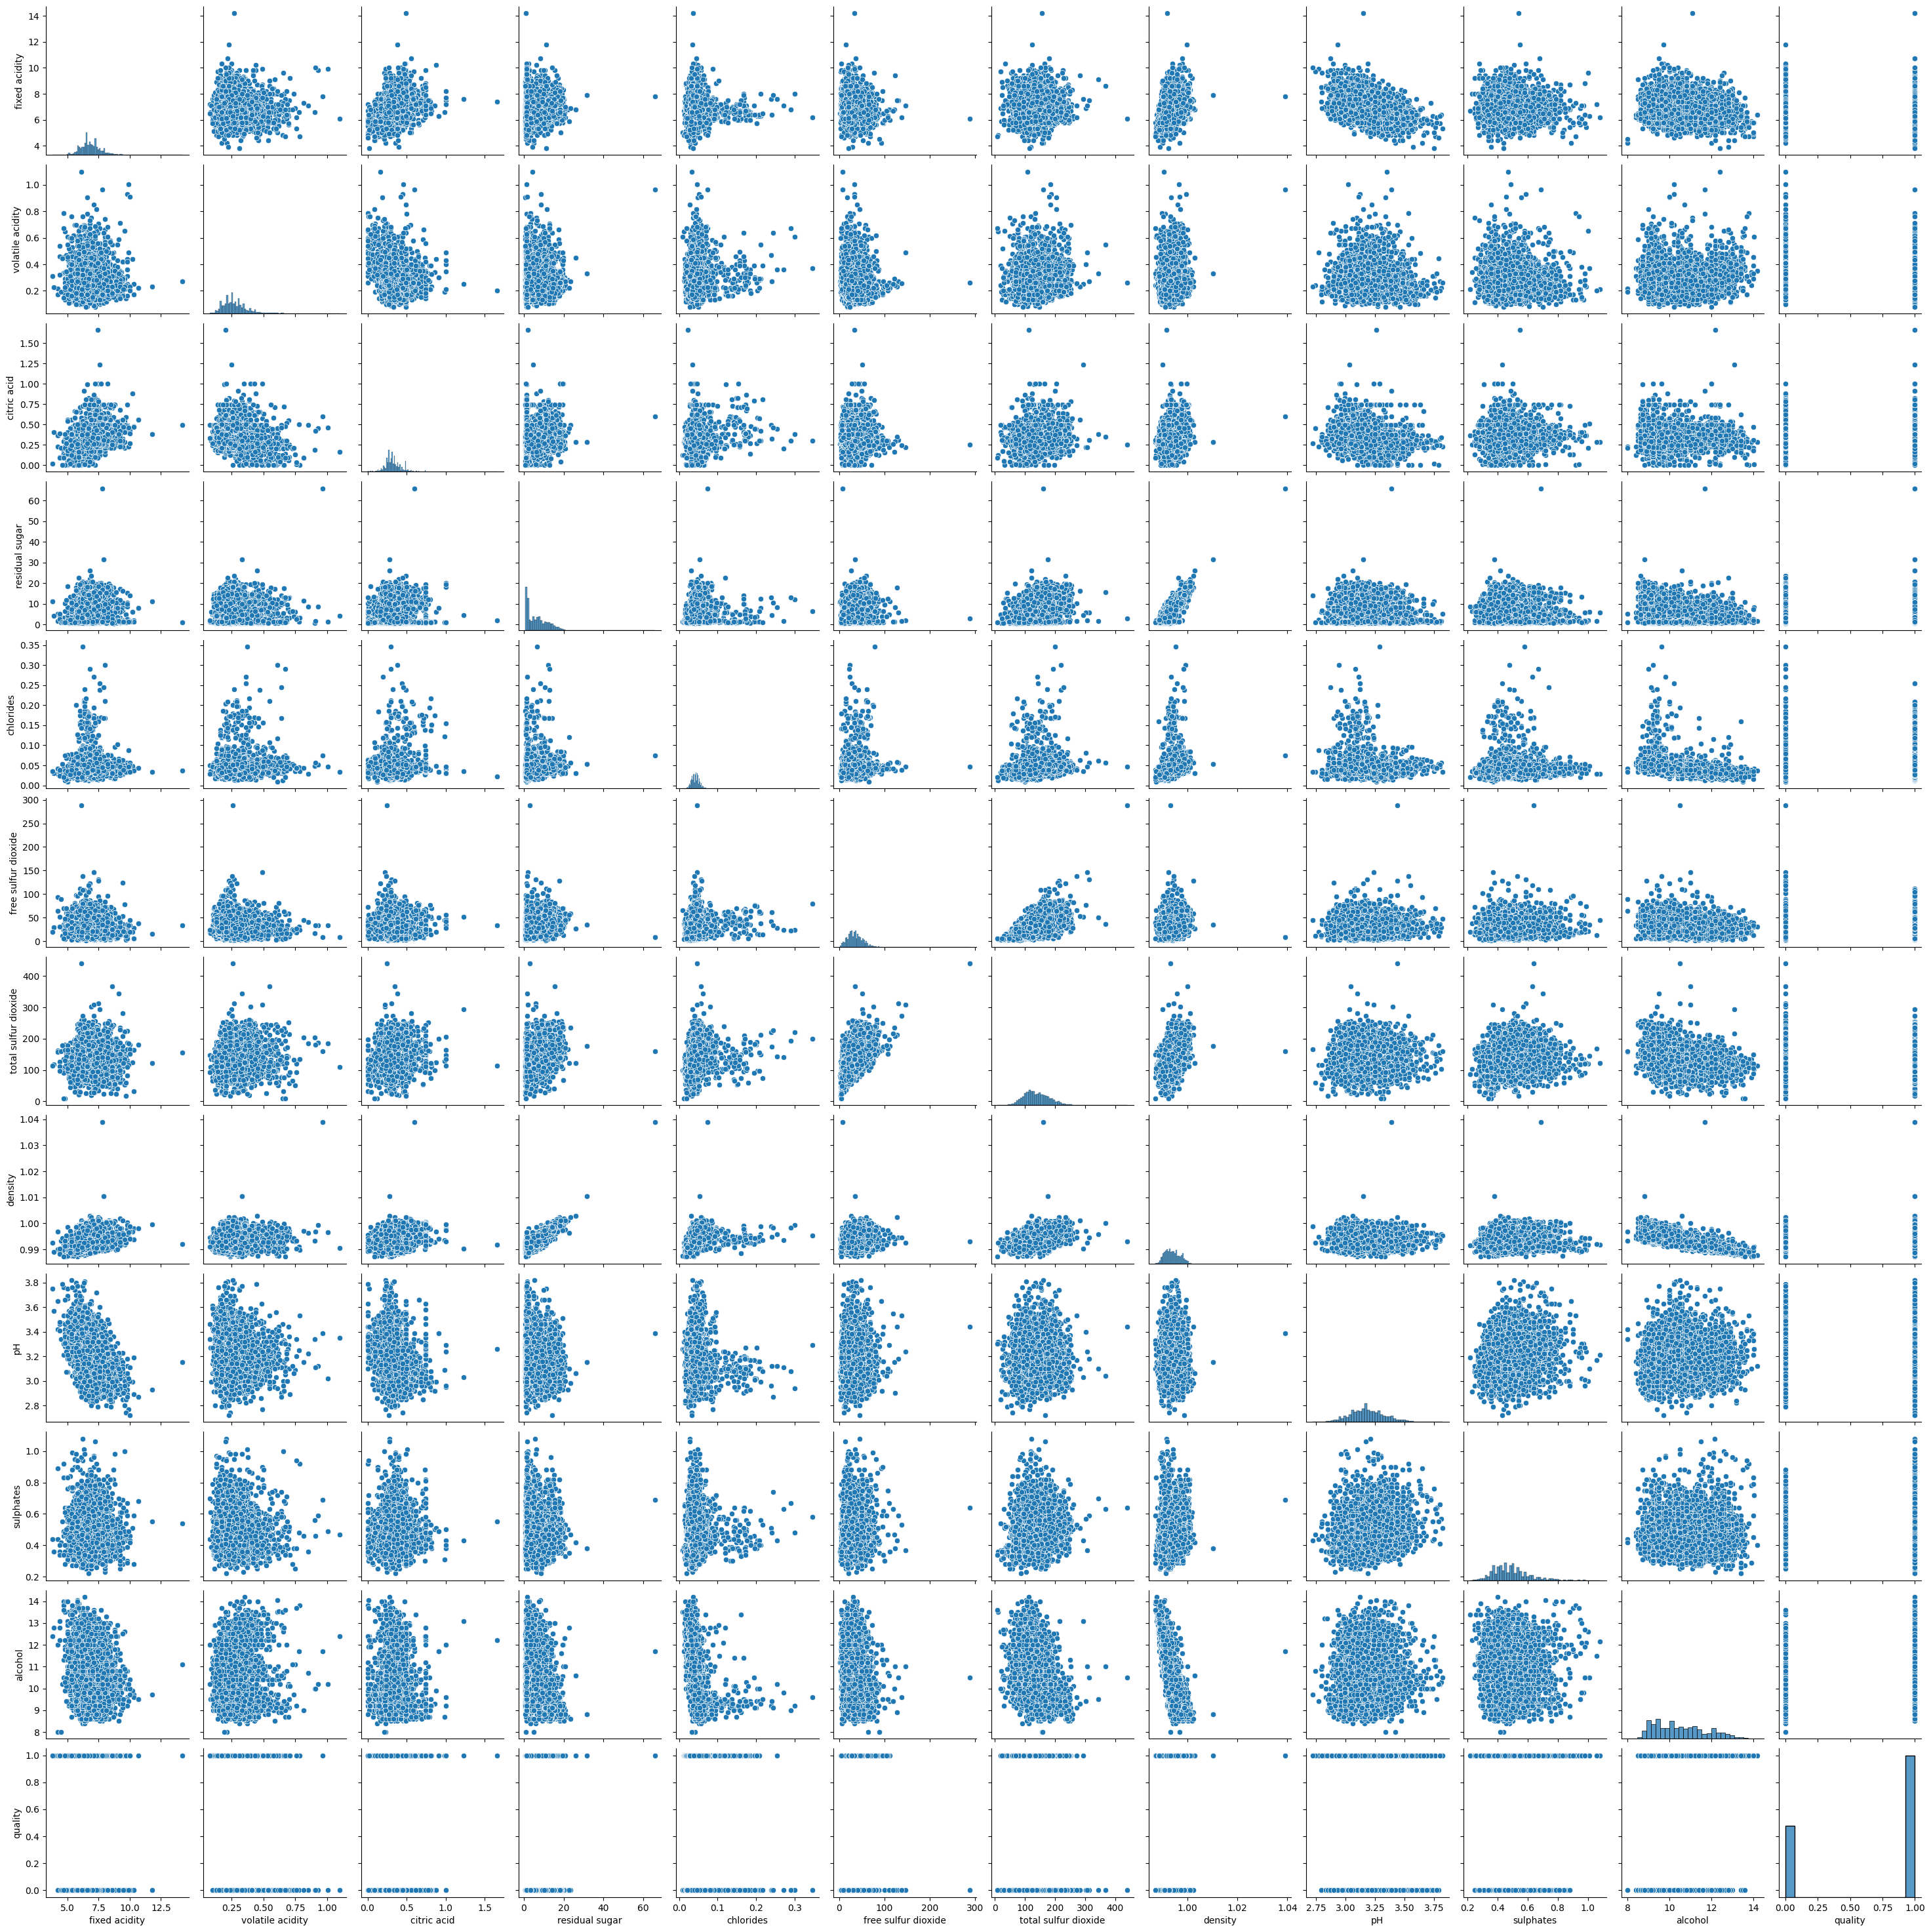

In [79]:
wineQuality_white['quality'] = (wineQuality_white['quality'] > 5).astype(int)
wineQuality_white = wineQuality_white.sample(frac=1).reset_index(drop=True)
sns.pairplot(wineQuality_white)
plt.show()

In [80]:
def partition(features, target, t):
    n_samples = len(features)
    n_train = int(n_samples * (1 - t))

    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    return X_train, X_test, y_train, y_test


X = wineQuality_white.drop('quality', axis=1).values
y = wineQuality_white['quality'].values

X_train, X_test, y_train, y_test = partition(X, y, 0.2)

In [81]:
def standardize(X):
    X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_standardized


X_train_standardized = standardize(X_train)
X_test_standardized = standardize(X_test)

In [ ]:
""" evaluate the performance of your model over each combination of k and distance metrics from the following sets:
    k=[1,5,9,11]  distance = [Euclidean, Manhattan]  weights = [uniform, distance] """
k_values = [1, 5, 9, 11]
distance_metrics = ['euclidean', 'manhattan']
weights = ['uniform', 'distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# compare the performance of your model with the performance of the KNeighborsClassifier from sklearn
# using the same combinations of k and distance metrics.
for k in k_values:
    for distance in distance_metrics:
        for weight in weights:
            wineQuality_white_classifier = KNN_Classifier()
            wineQuality_white_classifier.fit(X_train_standardized, y_train, k, weight, distance)
            y_pred = wineQuality_white_classifier.predict(X_test_standardized)
            print(f'k = {k}, distance = {distance}, weight = {weight}')
            print(f'Precision: {precision_score(y_test, y_pred)}')
            print(f'Recall: {recall_score(y_test, y_pred)}')
            print(f'F1 Score: {f1_score(y_test, y_pred)}')
            print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')
            print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
            print('-----------------------------------')

            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=distance)
            knn.fit(X_train_standardized, y_train)
            y_pred = knn.predict(X_test_standardized)
            print(f'k = {k}, distance = {distance}, weight = {weight}')
            print(f'Precision: {precision_score(y_test, y_pred)}')
            print(f'Recall: {recall_score(y_test, y_pred)}')
            print(f'F1 Score: {f1_score(y_test, y_pred)}')
            print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')
            print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
            print('-----------------------------------')

k = 1, distance = euclidean, weight = uniform
Precision: 0.6722306525037937
Recall: 0.6661654135338346
F1 Score: 0.6691842900302115
Confusion Matrix: [[ 99 216]
 [222 443]]
Accuracy: 0.5530612244897959
-----------------------------------
k = 1, distance = euclidean, weight = uniform
Precision: 0.6707132018209409
Recall: 0.6646616541353384
F1 Score: 0.6676737160120846
Confusion Matrix: [[ 98 217]
 [223 442]]
Accuracy: 0.5510204081632653
-----------------------------------
k = 1, distance = euclidean, weight = distance
Precision: 0.6722306525037937
Recall: 0.6661654135338346
F1 Score: 0.6691842900302115
Confusion Matrix: [[ 99 216]
 [222 443]]
Accuracy: 0.5530612244897959
-----------------------------------
k = 1, distance = euclidean, weight = distance
Precision: 0.6707132018209409
Recall: 0.6646616541353384
F1 Score: 0.6676737160120846
Confusion Matrix: [[ 98 217]
 [223 442]]
Accuracy: 0.5510204081632653
-----------------------------------
k = 1, distance = manhattan, weight = uniform
